# Total variation in-painting



## Grayscale Images

A grayscale image is represented as an $m \times n$ matrix of intensities
$U^\mathrm{orig}$ (typically between the values $0$ and $255$).
We are given the values $U^\mathrm{orig}_{ij}$, for $(i,j) \in \mathcal K$, where
$\mathcal K \subset \{1,\ldots, m\} \times \{1, \ldots, n\}$ is the set of indices
corresponding to known pixel values.
Our job is to *in-paint* the image by guessing the missing pixel values,
*i.e.*, those with indices not in $\mathcal K$.
The reconstructed image will be represented by $U \in {\bf R}^{m \times n}$,
where $U$ matches the known pixels, *i.e.*,
$U_{ij} = U^\mathrm{orig}_{ij}$ for $(i,j) \in \mathcal K$.

The reconstruction $U$ is found by minimizing the total variation of $U$,
subject to matching the known pixel values. We will use the $\ell_2$ total
variation, defined as
$$\mathop{\bf tv}(U) =
\sum_{i=1}^{m-1} \sum_{j=1}^{n-1}
\left\| \left[ \begin{array}{c}
 U_{i+1,j}-U_{ij}\\ U_{i,j+1}-U_{ij} \end{array} \right] \right\|_2.$$
Note that the norm of the discretized gradient is *not* squared.


Based on a tutorial from https://www.cvxpy.org
<br>https://www.cvxpy.org/examples/applications/tv_inpainting.html

We load the original image and the corrupted image and construct the Known matrix. Both images are displayed below. The corrupted image has the missing pixels whited out.

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import cvxpy as cvx
#from cvxpy import *
import matplotlib.cm as cm

import numpy as np
%matplotlib inline


(1, 1)
(9, 3)


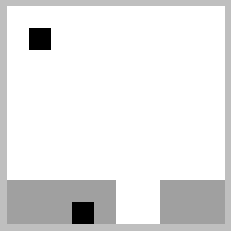

In [2]:
# Load the images.
orig_img = Image.open("data tv_inpainting/simple.png")

# Convert to arrays.
Uorig = np.array(orig_img)
Uorig = Uorig[:,:,0]
rows, cols = Uorig.shape

# Known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
Known = np.zeros((rows, cols))
for i in range(rows):
    for j in range(cols):
        #In "simple.png", an unknown pixel is marked as black
            if Uorig[i, j] != 0:
                Known[i, j] = 1
            else:
                print((i,j))
plt.style.use('grayscale')
plt.imshow(orig_img);
plt.axis('off');

We use the solver SCS, which finds the optimal value in a few seconds. The solvers ECOS and CVXOPT take much longer to solve this large problem; the exact amount depends on your machine.
To describe the total variation objective, we need to understand the cvxpy syntax and limitations.
In CVXPY,  every cvx problem needs to be defined using basic operators, functions, and their combinations. 
for a list, see:
(https://www.cvxpy.org/tutorial/functions/index.html#functions)

Complete the problem objeective using "norm" function and "vstack" function.




**sourse link:**<br>https://www.cvxpy.org/_modules/cvxpy/atoms/total_variation.html

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 32903
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 6661, constraints m = 19783
Cones:	primal zero / dual free vars: 100
	soc vars: 19683, soc blks: 6561
Setup time: 3.18e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.25e+21  1.17e+21  1.00e+00 -1.96e+25  5.05e+23  5.88e+24  5.88e-03 
   100| 1.68e-03  1.11e-02  8.91e-04  8.51e+02  8.52e+02  2.17e-13  4.58e-01 
   200| 9.11e-06  6.78e-05  8.28e-07  8.55e+02  8.55e+02  8.86e-13  8.4

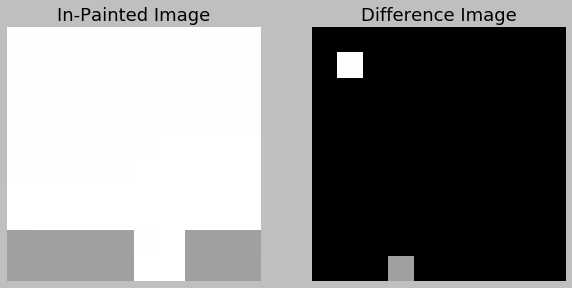

In [3]:
# Recover the original image using total variation in-painting.
#variable for each pixel
U = cvx.Variable(shape=(rows, cols))
diffs=[]

#add total variation objective explicitly  (part of cvx.tv(U))
diffs += [U[0:rows-1, 1:cols] - U[0:rows-1, 0:cols-1],
          U[1:rows, 0:cols-1] - U[0:rows-1, 0:cols-1]]
length = diffs[0].shape[0]*diffs[1].shape[1]
stacked = cvx.vstack([cvx.reshape(diff, (1, length)) for diff in diffs])
obj = cvx.Minimize(sum(cvx.norm(stacked, p=2, axis=0)))
    
#add constraints using "multiply" function
constraints = [cvx.multiply(Known, U) == cvx.multiply(Known, Uorig)]
prob = cvx.Problem(obj, constraints)
# Use SCS to solve the problem.
prob.solve(verbose=True, solver=cvx.SCS)

fig, ax = plt.subplots(1, 2,figsize=(10, 5))
# Display the in-painted image.
img_rec = Image.fromarray(U.value)
ax[0].imshow(img_rec);
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

img_diff = Image.fromarray(np.abs(Uorig - U.value))
ax[1].imshow(img_diff);
ax[1].set_title("Difference Image")
ax[1].axis('off');

Here's an example for a larger image, Lena:

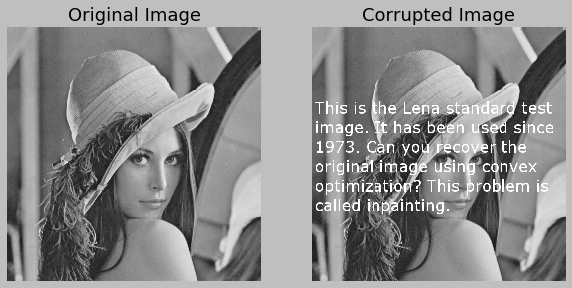

In [4]:
# Load the images.
orig_img = Image.open("data tv_inpainting/lena256.png")
corr_img = Image.open("data tv_inpainting/lena256_corrupted.png")

# Convert to arrays.
Uorig =np.array(orig_img)
Ucorr = np.array(corr_img)

rows, cols = Uorig.shape

# known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
known = np.zeros((rows, cols))
for i in range(rows):
    for j in range(cols):
         if Uorig[i, j] == Ucorr[i, j]:
            known[i, j] = 1

fig, ax = plt.subplots(1, 2,figsize=(10, 5))
ax[0].imshow(orig_img);
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(corr_img);
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

Now, instead of explicitly describing the total variation in-painting problem, we'll use a function directly expresssing that.

In [5]:
# Recover the original image using total variation in-painting.
U = cvx.Variable(shape=(rows, cols))
obj = cvx.Minimize(cvx.tv(U))
constraints = [cvx.multiply(known, U) == cvx.multiply(known, corr_img)]
prob = cvx.Problem(obj, constraints)

# Use SCS to solve the problem.
prob.solve(verbose=True, solver=cvx.SCS)

print("optimal objective value: {}".format(obj.value))

----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 385588
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 130561, constraints m = 260611
Cones:	primal zero / dual free vars: 65536
	soc vars: 195075, soc blks: 65025
Setup time: 4.29e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.49e+21  5.41e+21  1.00e+00 -2.23e+28  7.49e+26  5.22e+27  4.61e-02 
   100| 1.87e-03  2.57e-03  6.60e-04  8.48e+05  8.49e+05  2.03e-11  7.08e+00 
   200| 1.95e-04  3.24e-04  1.25e-05  8.49e+05  8.49e+05  2.31e

After solving the problem, the in-painted image is stored in `U.value`. We display the in-painted image and the intensity difference between the original and in-painted images. The intensity difference is magnified by a factor of 10 so it is more visible.

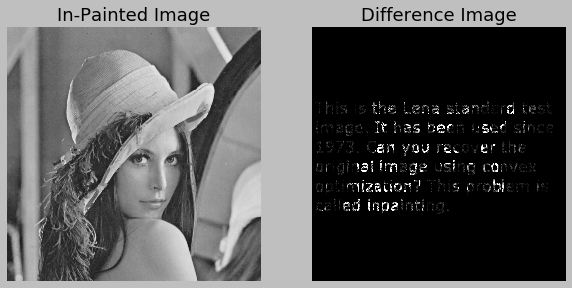

In [6]:
fig, ax = plt.subplots(1, 2,figsize=(10, 5))

# Display the in-painted image.
img_rec = Image.fromarray(U.value)
#ax[0].imshow(U.value, cmap='gray');
ax[0].imshow(img_rec,cmap='gray')
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

#img_diff = 10*np.abs(u_orig - U.value)
img_diff = Image.fromarray(10*np.abs(Uorig - U.value))
ax[1].imshow(img_diff,cmap='gray')
ax[1].set_title("Difference Image")
ax[1].axis('off');


# Color Images

For color images, the in-painting problem is similar to the grayscale case. A color image is represented as an $m \times n \times 3$ matrix of RGB values
$U^\mathrm{orig}$ (typically between the values $0$ and $255$).
We are given the pixels $U^\mathrm{orig}_{ij}$, for $(i,j) \in \mathcal K$, where
$\mathcal K \subset \{1,\ldots, m\} \times \{1, \ldots, n\}$ is the set of indices
corresponding to known pixels. Each pixel $U^\mathrm{orig}_{ij}$ is a vector in ${\bf R}^3$ of RGB values.
Our job is to *in-paint* the image by guessing the missing pixels,
*i.e.*, those with indices not in $\mathcal K$.
The reconstructed image will be represented by $U \in {\bf R}^{m \times n \times 3}$,
where $U$ matches the known pixels, *i.e.*,
$U_{ij} = U^\mathrm{orig}_{ij}$ for $(i,j) \in \mathcal K$.

The reconstruction $U$ is found by minimizing the total variation of $U$,
subject to matching the known pixel values. We will use the $\ell_2$ total
variation, defined as
$$\mathop{\bf tv}(U) =
\sum_{i=1}^{m-1} \sum_{j=1}^{n-1}
\left\| \left[ \begin{array}{c}
 U_{i+1,j}-U_{ij}\\ 
 U_{i,j+1}-U_{ij} 
 \end{array} \right] \right\|_2.$$
Note that the norm of the discretized gradient is *not* squared.

We load the original image and construct the Known matrix by randomly selecting 30% of the pixels to keep and discarding the others. The original and corrupted images are displayed below. The corrupted image has the missing pixels blacked out.

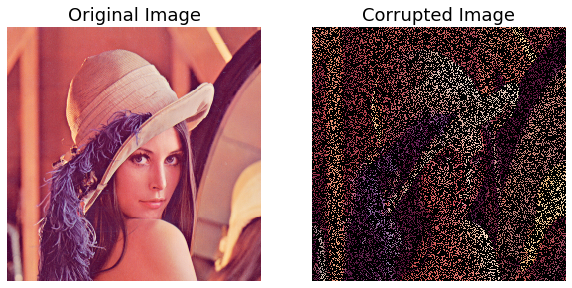

In [7]:

np.random.seed(1)
# Load the images.
orig_img = Image.open("data tv_inpainting/lena256color.tiff")

# Convert to arrays.
Uorig = np.array(orig_img)
rows, cols, colors = Uorig.shape

# Known is 1 if the pixel is known,
# 0 if the pixel was corrupted.
# The Known matrix is initialized randomly.
Known = np.zeros((rows, cols, colors))
for i in range(rows):
    for j in range(cols):
        if np.random.random() > 0.7:
            for k in range(colors):
                Known[i, j, k] = 1
            
Ucorr = Known*Uorig
corr_img = Image.fromarray(np.uint8(Ucorr))

# Display the images.
%matplotlib inline
fig, ax = plt.subplots(1, 2,figsize=(10, 5))
ax[0].imshow(orig_img);
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(corr_img);
ax[1].set_title("Corrupted Image")
ax[1].axis('off');

We express the total variation color in-painting problem in CVXPY using three matrix variables (one for the red values, one for the blue values, and one for the green values). Again we use the solver SCS. The solvers ECOS and CVXOPT don't scale to this large problem.
Naturally, this problem takes much more time to solve than the previous one.

In [ ]:
# Recover the original image using total variation in-painting.
variables = []
constraints = []
#construct problem constraints
for i in range(colors):
    #add constratins for that color channel (r, g or b)
    U = cvx.Variable(shape=(rows, cols))
    variables.append(U)
    constraints.append(cvx.multiply(Known[:, :, i], U) == cvx.multiply(Known[:, :, i], Ucorr[:, :, i]))
prob = cvx.Problem(cvx.Minimize(cvx.tv(*variables)), constraints)
prob.solve(verbose=True, solver=cvx.SCS)
print("optimal objective value: {}".format(prob.value))


WARN: A->p (column pointers) not strictly increasing, column 130560 empty
WARN: A->p (column pointers) not strictly increasing, column 196096 empty
WARN: A->p (column pointers) not strictly increasing, column 261632 empty
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 904128
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 261633, constraints m = 651783
Cones:	primal zero / dual free vars: 196608
	soc vars: 455175, soc blks: 65025
Setup time: 1.32e+00s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
-------------------------------------------------------------------------

After solving the problem, the RGB values of the in-painted image are stored in the value fields of the three variables. We display the in-painted image and the difference in RGB values at each pixel of the original and in-painted image. Though the in-painted image looks almost identical to the original image, you can see that many of the RGB values differ.

In [ ]:
# Load variable values into a single array.
rec_arr = np.zeros((rows, cols, colors), dtype=np.uint8)
for i in range(colors):
    rec_arr[:, :, i] = variables[i].value

fig, ax = plt.subplots(1, 2,figsize=(10, 5))
# Display the in-painted image.
img_rec = Image.fromarray(rec_arr)
ax[0].imshow(img_rec);
ax[0].set_title("In-Painted Image")
ax[0].axis('off')

#img_diff = np.clip(10 * np.abs(u_orig - rec_arr), 0, 1) b/w
img_diff = Image.fromarray(np.abs(Uorig - rec_arr))
ax[1].imshow(img_diff);
ax[1].set_title("Difference Image")
ax[1].axis('off');